In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

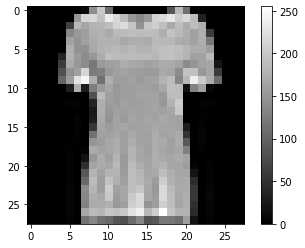

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

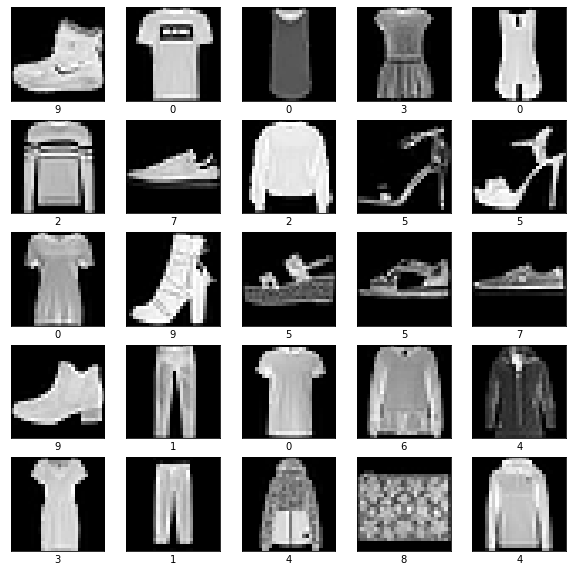

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Selección de 3 clases

Las clases seleccionadas son:

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 2     | Pullover    |
| 9     | Ankle boot  |


In [7]:
#Indices seleccionados
train_indices = (train_labels==0) + (train_labels==2) + (train_labels==9)
test_indices = (test_labels==0) + (test_labels==2) + (test_labels==9)

#Arreglos para entrenamiento y prueba
train_images = train_images[train_indices]
train_labels = train_labels[train_indices]
test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

## Diccionario de labels

In [8]:
diccionario_datos={
    0: "T-shirt/top",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

## Modelo TensorFlow

### Importando librerías

In [10]:
#Importando librerías
import pandas as pd
import numpy as np
#Importanto TensorFlow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
tf.enable_eager_execution()
from tensorflow.keras.callbacks import TensorBoard
#Librerias auxiliares
import os
import datetime
from IPython.display import Image
#Variable de entorno tf
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Modelo

In [11]:
class ModeloSoftmax:
            
    def __init__(self, x, y, diccionario):
        tf.reset_default_graph()
        self.g = tf.Graph()
        
        #Definición de variables a usar en la clase
        self.x = self.redimencionar_imagenes(x)
        self.y = pd.get_dummies(y)
        #Predicción
        self.columnas = self.y.columns
        self.y_original = y
        
        #Diccionario de prediccion
        self.diccionario = diccionario
        
        #Pesos
        self.w = np.zeros((self.x.shape[1], 3))
    
    #Redimencionar la imagen para utilizar el algoritmo softmax con cross entropy
    def redimencionar_imagenes(self, imagenes):
        imagenes_planas = imagenes.reshape(imagenes.shape[0], (imagenes.shape[1]*imagenes.shape[2]))
        return np.hstack(( imagenes_planas, np.ones((imagenes_planas.shape[0],1)) ))
    
    def entrenar(self, experimento, lr, w, iteraciones, tamaño_muestra, epochs, batch_size):
        
        #Grafo
        with self.g.as_default():
            
            #Definición de variables
            _x = tf.Variable(tf.zeros((batch_size, self.x.shape[1])), dtype=tf.dtypes.float32, name="x")
            _y = tf.Variable(tf.zeros((batch_size, 3)), dtype=tf.dtypes.float32, name="y")
            _w = tf.Variable(tf.zeros((self.x.shape[1], 3)), dtype=tf.dtypes.float32, name="w")
            _lr = tf.Variable(0.0, dtype=tf.dtypes.float32, name="lr")
            
            #Cálculo de perdida
            with tf.name_scope("perdida"):
                logits = tf.matmul(_x, _w, name="logits")
                error = tf.nn.softmax_cross_entropy_with_logits(labels=_y, logits=logits, name="error")
                perdida = tf.reduce_mean(error, name="perdida")
            
            #Gradiente
            with tf.name_scope("gradiente"):
                gradiente = tf.gradients(perdida, [_w], name="gradiente")
            
            #Recalculo de pesos
            with tf.name_scope("reajuste_pesos"):
                reajuste = tf.subtract(_w, tf.multiply(_lr,gradiente[0]), name="reajuste")
            
            #Cálculo de perdida
            with tf.name_scope("precision"):
                yhat = tf.matmul(_x, reajuste, name="yhat")
                p = tf.nn.softmax(yhat, name="probabilidad")
                prediccion = tf.argmax(p, axis=1, name="prediccion")
            
        #Sesión
        with tf.Session(graph=self.g) as sesion:
            #Escritura de log
            writer = tf.summary.FileWriter(
                os.path.join(
                    "./logs", 
                    experimento+"_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                ), 
                sesion.graph
            )
            
            #Epochs
            for epoch in range(epochs):
                #Iteraciones
                for iteracion in range(iteraciones):
                    #Tamaño de muestra
                    muestra_inicio =int(tamaño_muestra/epochs)*epoch
                    muestra_fin = muestra_inicio+batch_size
                    
                    #TensorFlow
                    [tf_perdida, w, yhat_batch, tf_prediccion] = sesion.run([perdida, reajuste, _y, prediccion], feed_dict = {
                        _x: self.x[muestra_inicio:muestra_fin,:],
                        _y: self.y[muestra_inicio:muestra_fin],
                        _w: w,
                        _lr: lr
                    }) 
                    
                    #Cálculo de presición
                    precision = np.sum(yhat_batch[np.arange(len(yhat_batch)), tf_prediccion])/batch_size
                    
                    #Escribiendo en TensorBoard
                    writer.add_summary( tf.Summary(value=[tf.Summary.Value(tag="precision", simple_value=precision)]), epoch*epochs + iteracion)
                    writer.add_summary( tf.Summary(value=[tf.Summary.Value(tag="perdida", simple_value=tf_perdida)]), epoch*epochs + iteracion)
                    
                
            writer.close()
        
        #Retornando pesos
        return w
    
    #Regresa solo los labels de las imagenes
    def prediccion(self, x, w):
        _prediccion = self.prediccion_probabilidad(x, w)
        return _prediccion[1]
    
    #Regresa un vector con la matriz de probabilidades y los nombres de los labels de las imagenes
    def prediccion_probabilidad(self, x, w):
        x_plano = self.redimencionar_imagenes(x)
        yhat = tf.matmul(x_plano, w)
        p = tf.nn.softmax(yhat)
        indice_prediccion = np.argmax(p, axis=1)
        indices_columnas = self.columnas[indice_prediccion]
        
        return [p.numpy(), np.array(list( map(diccionario_datos.get, indices_columnas) ))]
    
    #Graficar 5 imagenes aleatorias
    def graficar(self, x, w):
        prediccion = self.prediccion_probabilidad(x, w)
        
        plt.figure(figsize=(10,10))
        for i in range(len(x)):
            plt.subplot(5,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i], cmap='gray')
            plt.xlabel(prediccion[1][i]+", p="+str(np.round(max(prediccion[0][i]),2)))
        plt.show()
        
        

#### Grafo de TensorFlow

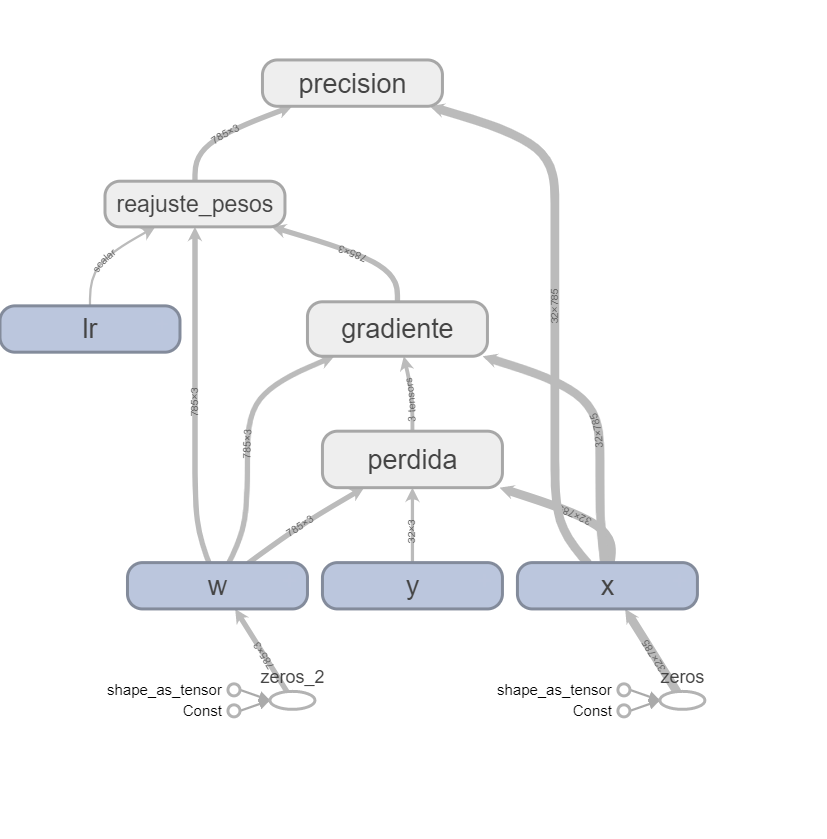

In [12]:
Image(filename='grafo.png')

## Predicción de datos

### Datos sin normalización

#### Creando el modelo

In [13]:
modelo_softmax_1 = ModeloSoftmax(train_images, train_labels, diccionario_datos)

#### Experimento 1

In [15]:
lr_ = 0.00000003
w_ = np.zeros(((train_images.shape[1]*train_images.shape[2])+1, 3))
iteraciones_ = 10
tamaño_muestra_ = len(train_images)
epochs_ = 562
batch_size_ = 32
w_exp1 = modelo_softmax_1.entrenar("lr3x-8_i10", lr_, w_, iteraciones_, tamaño_muestra_, epochs_, batch_size_)

##### Predicción

Predicción del set de datos de pruebas y cálculo de presición

In [16]:
prediccion = modelo_softmax_1.prediccion(test_images, w_exp1)
labels_reales = np.array(list(map(diccionario_datos.get, test_labels)))
presicion = sum(np.array(labels_reales)==np.array(prediccion))/len(np.array(labels_reales))

print(prediccion[0:4],"...")
print("Presición:",presicion)

['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top'] ...
Presición: 0.968


#### Experimento 2

In [17]:
lr_ = 0.00000003
w_ = np.zeros(((train_images.shape[1]*train_images.shape[2])+1, 3))
iteraciones_ = 50
tamaño_muestra_ = len(train_images)
epochs_ = 562
batch_size_ = 32
w_exp2 = modelo_softmax_1.entrenar("lr3x-8_i50", lr_, w_, iteraciones_, tamaño_muestra_, epochs_, batch_size_)

##### Predicción

Predicción del set de datos de pruebas y cálculo de presición

In [18]:
prediccion = modelo_softmax_1.prediccion(test_images, w_exp2)
labels_reales = np.array(list(map(diccionario_datos.get, test_labels)))
presicion = sum(np.array(labels_reales)==np.array(prediccion))/len(np.array(labels_reales))

print(prediccion[0:4],"...")
print("Presición:",presicion)

['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top'] ...
Presición: 0.969


#### Evaluación de experimento 1 y 2

Al aumentar la cantidad de iteraciones en el algoritmo mini-batch es posible observar en TensorBoard que el la perdida converge a un valor inferior y la presición aumenta únicamente en 0.001. Se utilizarán los resultados del experimento 2.

Gráfica de perdida TensorBoard

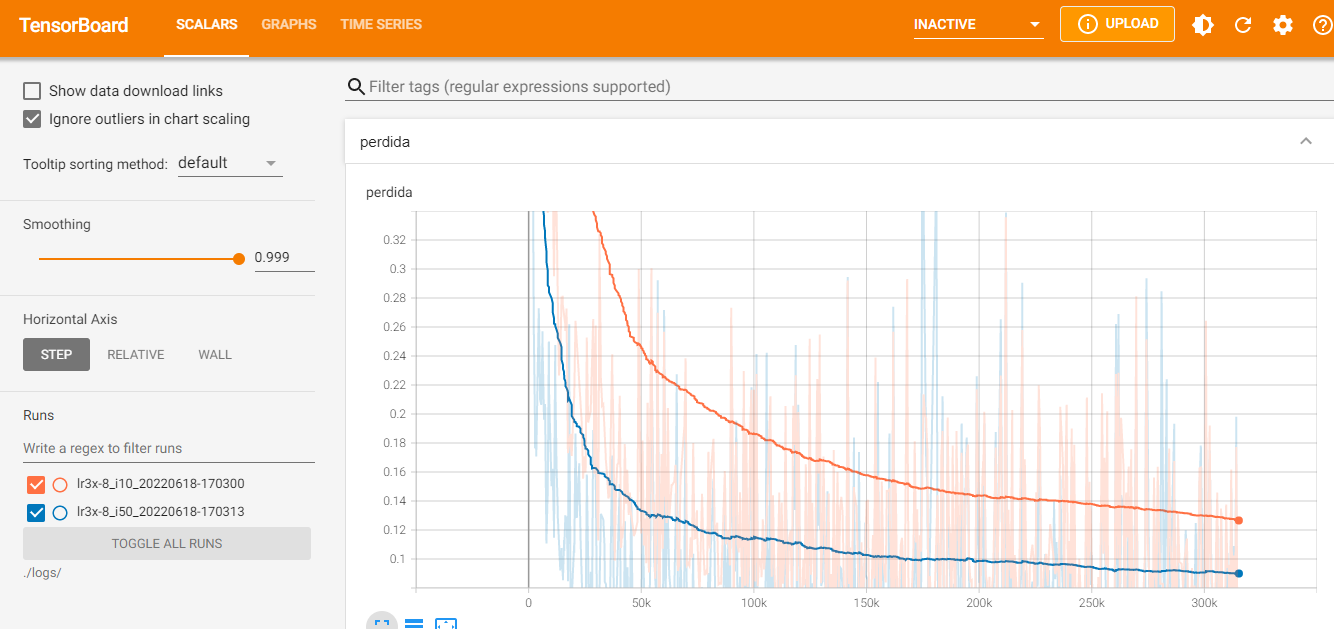

In [19]:
Image(filename='perdida.png')

Gráfica de presición TensorBoard

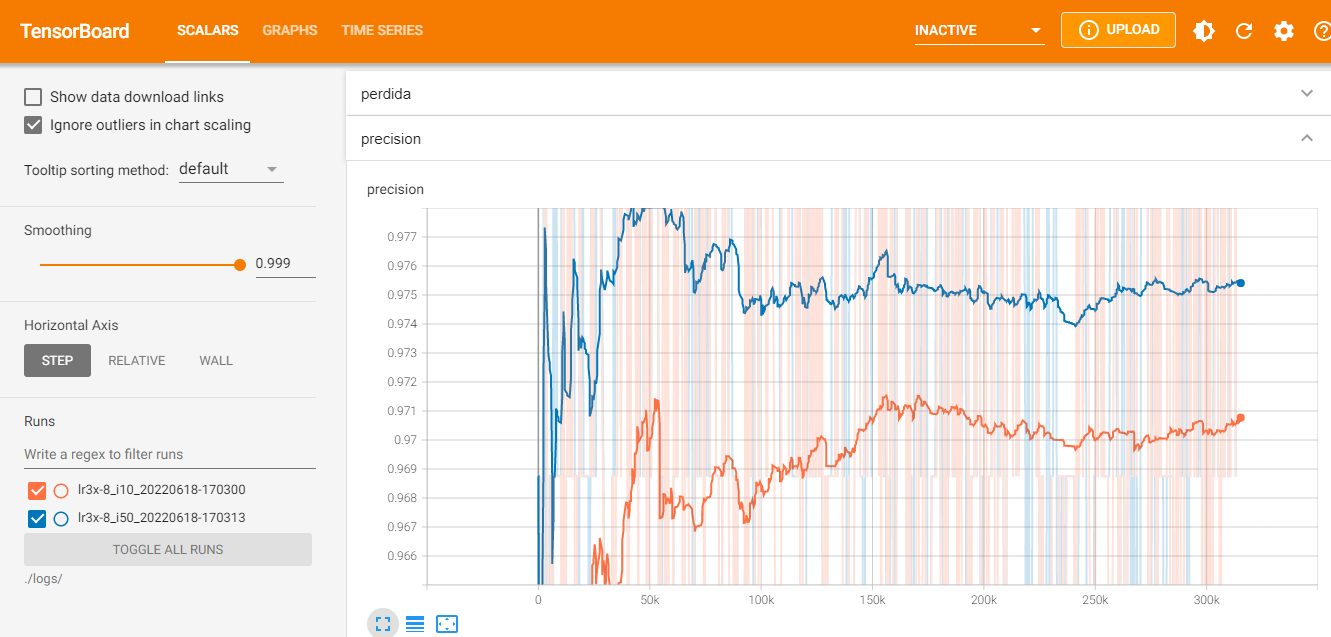

In [20]:
Image(filename='presicion.png')

#### Predicción de 5 imagenes aleatorias

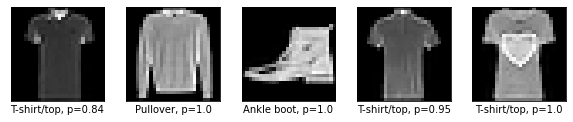

In [21]:
indices_aleatorios = np.random.choice(test_images.shape[0], 5, replace=False)
modelo_softmax_1.graficar(test_images[indices_aleatorios] , w_exp2)

### Datos con normalización

#### Normalización

In [22]:
mean_images = np.mean(train_images)
std_images = np.std(train_images)
norm_train_images = (train_images - mean_images)/std_images
norm_test_images = (test_images - mean_images)/std_images

#### Creando el modelo

In [23]:
modelo_softmax_2 = ModeloSoftmax(norm_train_images, train_labels, diccionario_datos)

#### Experimento 3

In [24]:
lr_ = 0.00000003
w_ = np.zeros(((norm_train_images.shape[1]*norm_train_images.shape[2])+1, 3))
iteraciones_ = 10
tamaño_muestra_ = len(norm_train_images)
epochs_ = 562
batch_size_ = 32
w_exp3 = modelo_softmax_2.entrenar("norm_lr3x-8_i10", lr_, w_, iteraciones_, tamaño_muestra_, epochs_, batch_size_)

##### Predicción

Predicción del set de datos de pruebas y cálculo de presición

In [25]:
prediccion = modelo_softmax_2.prediccion(norm_test_images, w_exp3)
labels_reales = np.array(list(map(diccionario_datos.get, test_labels)))
precision = sum(np.array(labels_reales)==np.array(prediccion))/len(np.array(labels_reales))

print(prediccion[0:4],"...")
print("Presición:",presicion)

['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top'] ...
Presición: 0.969


#### Experimento 4

In [26]:
lr_ = 0.00000003
w_ = np.zeros(((norm_train_images.shape[1]*norm_train_images.shape[2])+1, 3))
iteraciones_ = 50
tamaño_muestra_ = len(norm_train_images)
epochs_ = 562
batch_size_ = 32
w_exp4 = modelo_softmax_2.entrenar("norm_lr3x-8_i50", lr_, w_, iteraciones_, tamaño_muestra_, epochs_, batch_size_)

##### Predicción

Predicción del set de datos de pruebas y cálculo de presición

In [27]:
prediccion = modelo_softmax_2.prediccion(norm_test_images, w_exp4)
labels_reales = np.array(list(map(diccionario_datos.get, test_labels)))
precision = sum(np.array(labels_reales)==np.array(prediccion))/len(np.array(labels_reales))

print(prediccion[0:4],"...")
print("Presición:",presicion)

['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top'] ...
Presición: 0.969


#### Evaluación de experimento 3 y 4

Se utilizarán los resultados del experimento 4, la diferencia de la presición entre ambos es de 0.057. En los gráficos de perdida, es posible ver que el error tiende a 1 al utilizar datos normalizados.

Gráfica de perdida TensorBoard

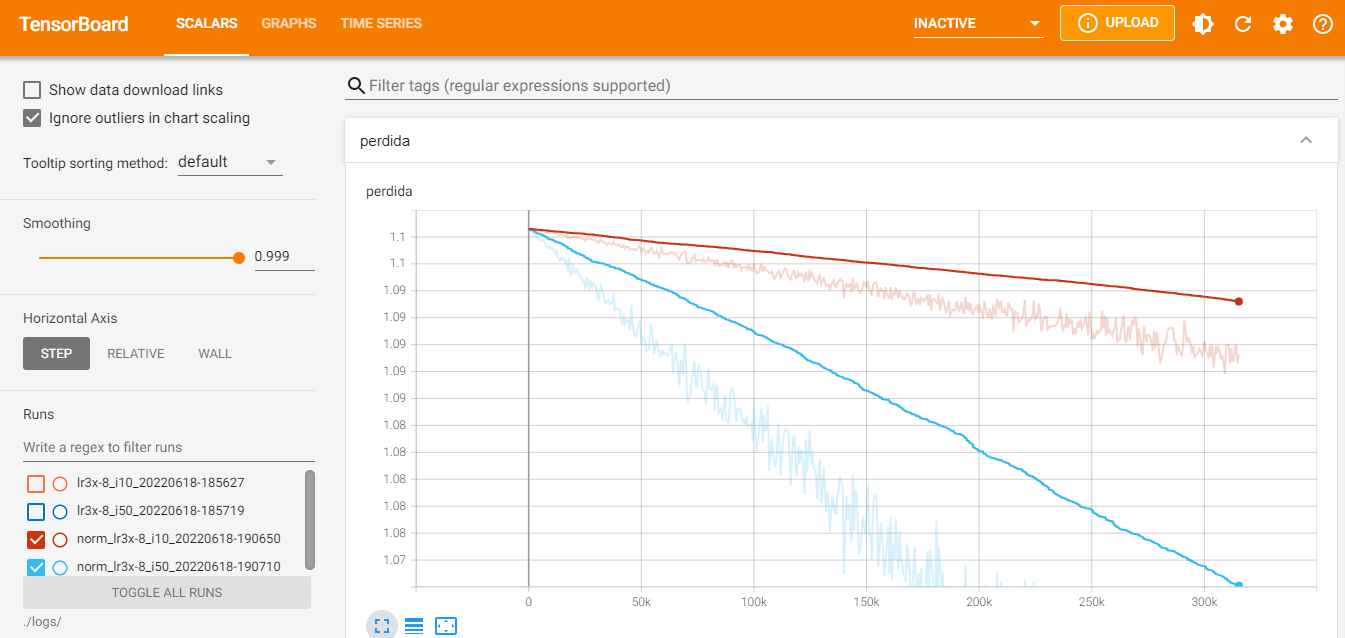

In [28]:
Image(filename='norm_perdida.png')

Gráfica de presición TensorBoard

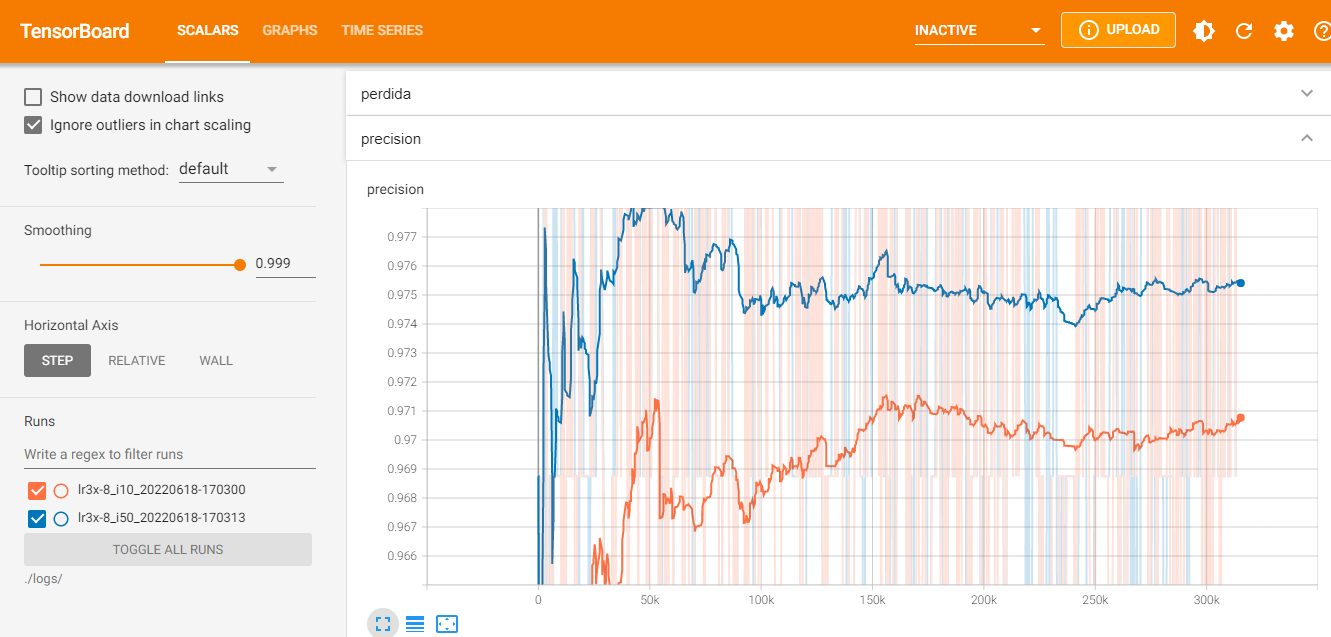

In [29]:
Image(filename='presicion.png')

#### Predicción de 5 imagenes aleatorias

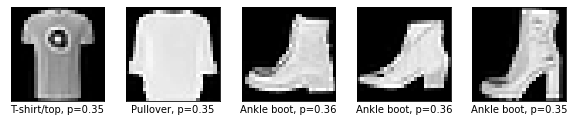

In [33]:
indices_aleatorios = np.random.choice(norm_test_images.shape[0], 5, replace=False)
modelo_softmax_2.graficar(norm_test_images[indices_aleatorios] , w_exp4)

In [ ]:
## Conclusión




Gráfica de comparación de perdida Tensorboard

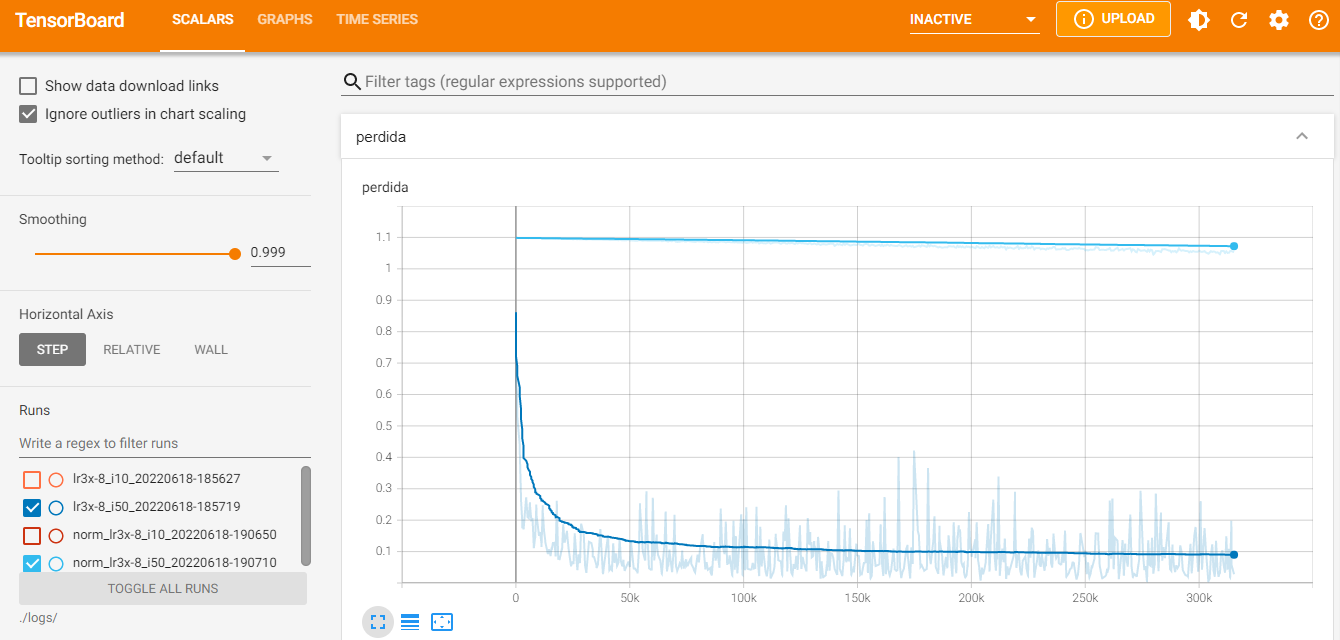

In [31]:
Image(filename='comparacion_perdida.png')

Gráfica de comparación de presición TensorBoard

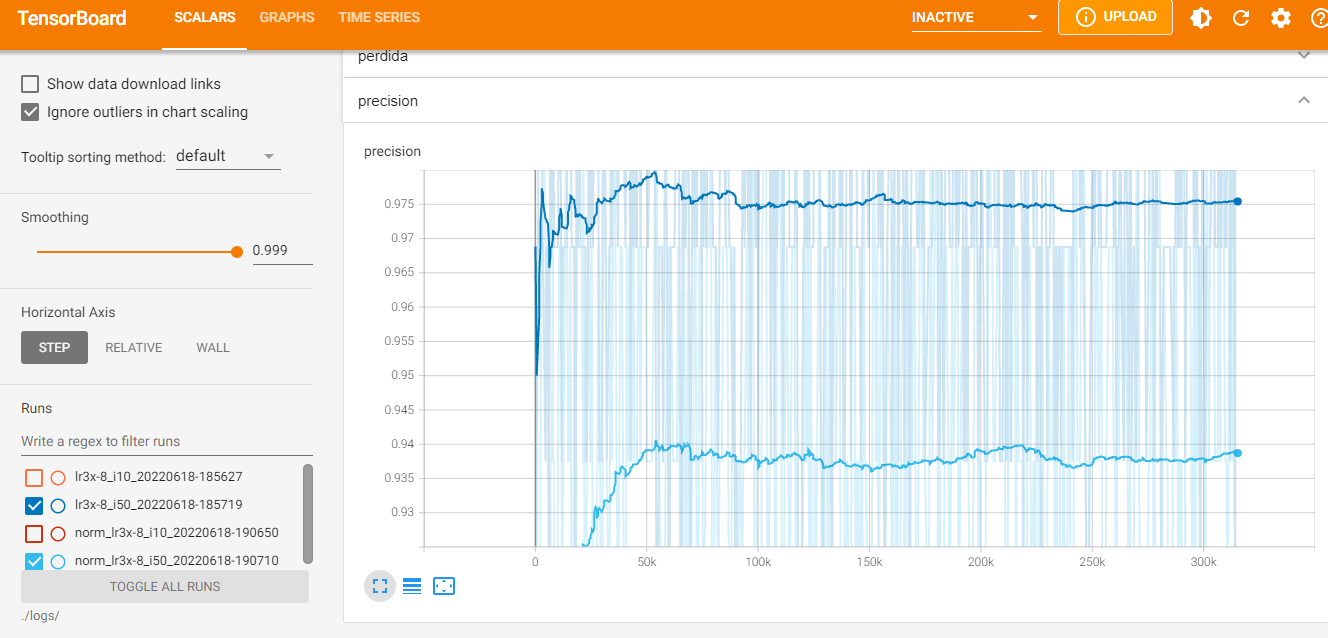

In [32]:
Image(filename='comparacion_presicion.png')